# Chapter 9 – Unsupervised Learning


First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Clustering

Introduction – Classification _vs_ Clustering

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

Saving figure classification_vs_clustering_plot


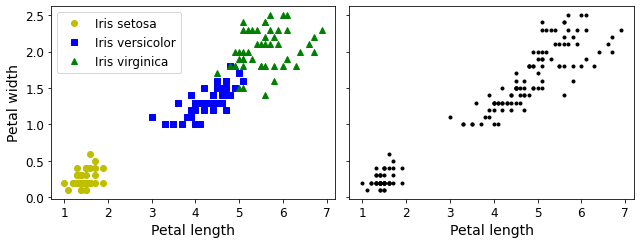

In [5]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

Figure 9-1. Classification (left) versus clustering (right)

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [6]:
from sklearn.mixture import GaussianMixture

In [7]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's map each cluster to a class. Instead of hard coding the mapping (as is done in the book, for simplicity), we will pick the most common class for each cluster (using the `scipy.stats.mode()` function):

In [8]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{1: 0, 2: 1, 0: 2}

In [9]:
mapping[1]

0

In [10]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

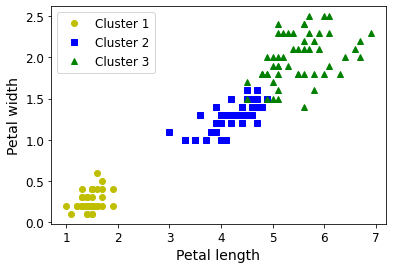

In [11]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [12]:
np.sum(y_pred==y)

145

In [13]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

### K-Means

Let's start by generating some blobs:

In [14]:
from sklearn.datasets import make_blobs

In [15]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [16]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Now let's plot them:

In [17]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


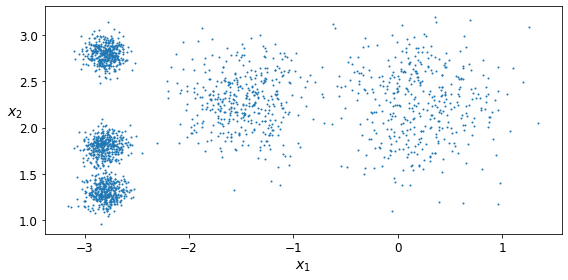

In [18]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

Figure 9-2. An unlabeled dataset composed of five blobs of instances

**Fit and Predict**

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [19]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:

In [20]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [21]:
len(y_pred)

2000

In [22]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [23]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [24]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

Of course, we can predict the labels of new instances:

In [25]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

**Decision Boundaries**

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [26]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


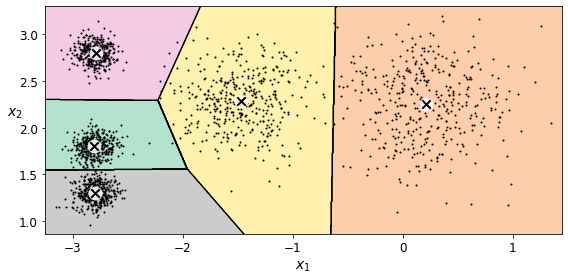

In [27]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Figure 9-3. K-Means decision boundaries (Voronoi tessellation)

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

**Hard Clustering _vs_ Soft Clustering**  

Instead of assigning each instance to a single cluster, which is called *hard clustering*, it can be useful to give each instance a score per cluster, which is called *soft clustering*. The score can be the distance between the instance and the centroid; conversely, it can be a similarity score (or affinity), such as the Gaussian Radial Basis Function (introduced in Chapter 5). In the KMeans class, the `transform()` method measures the distance from each instance to every centroid:

In [28]:
X_new

array([[ 0. ,  2. ],
       [ 3. ,  2. ],
       [-3. ,  3. ],
       [-3. ,  2.5]])

In [29]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [30]:
np.tile(X_new, (1, k)) # k=5

array([[ 0. ,  2. ,  0. ,  2. ,  0. ,  2. ,  0. ,  2. ,  0. ,  2. ],
       [ 3. ,  2. ,  3. ,  2. ,  3. ,  2. ,  3. ,  2. ,  3. ,  2. ],
       [-3. ,  3. , -3. ,  3. , -3. ,  3. , -3. ,  3. , -3. ,  3. ],
       [-3. ,  2.5, -3. ,  2.5, -3. ,  2.5, -3. ,  2.5, -3. ,  2.5]])

In [31]:
np.tile(X_new, (1, k)).reshape(-1, k, 2)

array([[[ 0. ,  2. ],
        [ 0. ,  2. ],
        [ 0. ,  2. ],
        [ 0. ,  2. ],
        [ 0. ,  2. ]],

       [[ 3. ,  2. ],
        [ 3. ,  2. ],
        [ 3. ,  2. ],
        [ 3. ,  2. ],
        [ 3. ,  2. ]],

       [[-3. ,  3. ],
        [-3. ,  3. ],
        [-3. ,  3. ],
        [-3. ,  3. ],
        [-3. ,  3. ]],

       [[-3. ,  2.5],
        [-3. ,  2.5],
        [-3. ,  2.5],
        [-3. ,  2.5],
        [-3. ,  2.5]]])

In [32]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [33]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [34]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter4 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=4, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)
kmeans_iter4.fit(X)

KMeans(algorithm='full', init='random', max_iter=4, n_clusters=5, n_init=1,
       random_state=0)

And let's plot this:

Saving figure kmeans_algorithm_plot


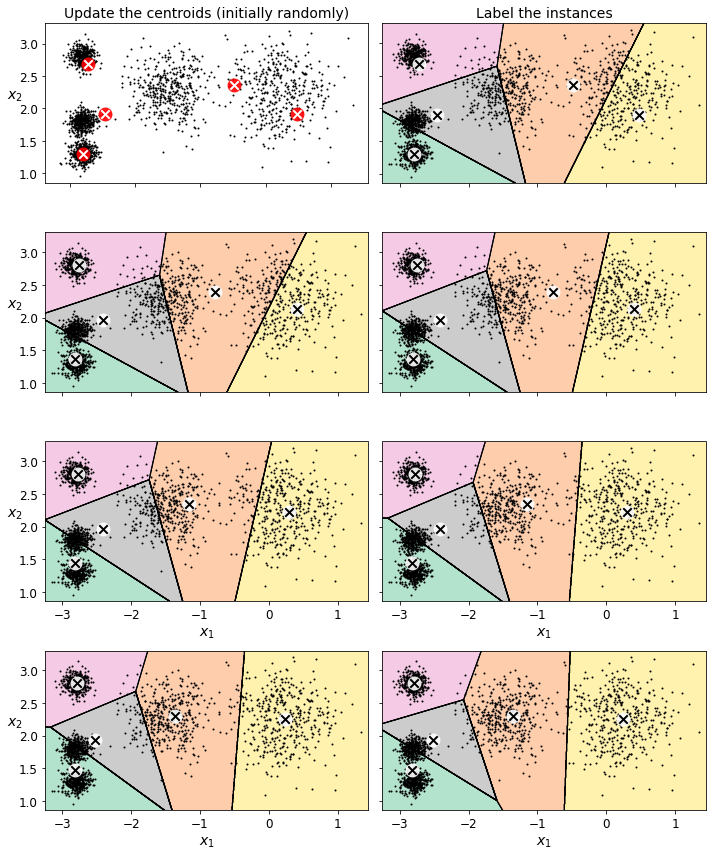

In [35]:
plt.figure(figsize=(10, 12))

plt.subplot(421)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(422)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(423)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(424)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(425)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(426)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.subplot(427)
plot_decision_boundaries(kmeans_iter3, X, show_centroids=False)
plot_centroids(kmeans_iter4.cluster_centers_)

plt.subplot(428)
plot_decision_boundaries(kmeans_iter4, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

Figure 9-4. The K-Means algorithm

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [36]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


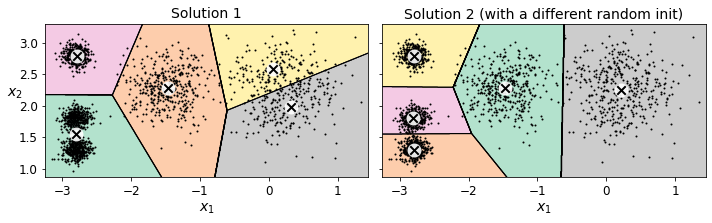

In [37]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

Figure 9-5. Suboptimal solutions due to unlucky centroid initializations

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [38]:
kmeans.inertia_

211.59853725816836

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [39]:
X_dist = kmeans.transform(X)
X_dist

array([[0.46779778, 3.04611916, 1.45402521, 1.54944305, 0.11146795],
       [0.07122059, 3.11541584, 0.99002955, 1.48612753, 0.51431557],
       [3.81713488, 1.32016676, 4.09069201, 2.67154781, 3.76340605],
       ...,
       [0.92830156, 3.04886464, 0.06769209, 1.40795651, 1.42865797],
       [3.10300136, 0.14895409, 3.05913478, 1.71125   , 3.23385668],
       [0.22700281, 2.8625311 , 0.85434589, 1.21678483, 0.67518173]])

In [40]:
np.arange(len(X_dist))

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [41]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [42]:
X_dist[np.arange(len(X_dist)), kmeans.labels_]

array([0.11146795, 0.07122059, 1.32016676, ..., 0.06769209, 0.14895409,
       0.22700281])

In [43]:
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.5985372581689

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

In [44]:
kmeans.score(X)

-211.59853725816834

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [45]:
kmeans_rnd_init1.inertia_

219.43539442771404

In [46]:
kmeans_rnd_init2.inertia_

211.5985372581683

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [47]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

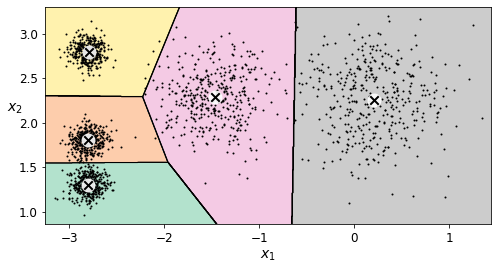

In [48]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

In [49]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

In [50]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

219.84385402233227

### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [51]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

The slowest run took 4.82 times longer than the fastest. This could mean that an intermediate result is being cached.
287 ms ± 178 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [52]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

94.5 ms ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


There's no big difference in this case, as the dataset is fairly small.

### Mini-Batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [53]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [54]:
minibatch_kmeans.inertia_

211.652398504332

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, just like we did for incremental PCA in the previous chapter. 
Alternatively, you can pass one mini-batch at a time to the `partial_fit()` method, but this will require much more work, since you will need to perform multiple initializations and select the best one yourself (see the mini-batch K-Means section of the notebook for an example).

Although the Mini-batch K-Means algorithm is much faster than the regular K-Means algorithm, its inertia is generally slightly worse, especially as the number of clusters increases. You can see this in Figure 9-6: the plot on the left compares the inertias of Mini-batch K-Means and regular K-Means models trained on the previous dataset using various numbers of clusters k. The difference between the two curves remains fairly constant, but this difference becomes more and more significant as k increases, since the inertia becomes smaller and smaller. In the plot on the right, you can see that Mini-batch K-Means is much faster than regular K-Means, and this difference increases with k.

First let's load MNIST:

In [55]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

Next, let's write it to a `memmap`:

In [57]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [58]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

If your data is so large that you cannot use `memmap`, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [59]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [60]:
np.random.seed(42)
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [61]:
best_kmeans.score(X)

-211.6257187889114

Mini-batch K-Means is much faster than regular K-Means:

In [62]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

84 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

55.2 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's *much* faster! However, its performance is often lower (higher inertia), and it keeps degrading as _k_ increases. Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

In [64]:
from timeit import timeit

In [65]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

Saving figure minibatch_kmeans_vs_kmeans


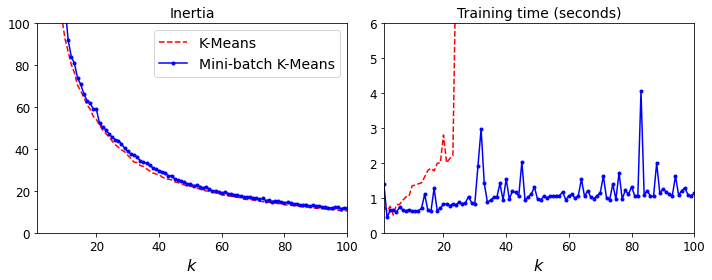

In [66]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

Figure 9-6. Mini-batch K-Means has a higher inertia than K-Means (left) but it is much faster (right), especially as k increases

### Finding the optimal number of clusters

So far, we have set the number of clusters k to 5 because it was obvious by looking at the data that this was the correct number of clusters. But in general, it will not be so easy to know how to set k, and the result might be quite bad if you set it to the wrong value. As you can see in Figure 9-7, setting k to 3 or 8 results in fairly bad models.


Saving figure bad_n_clusters_plot


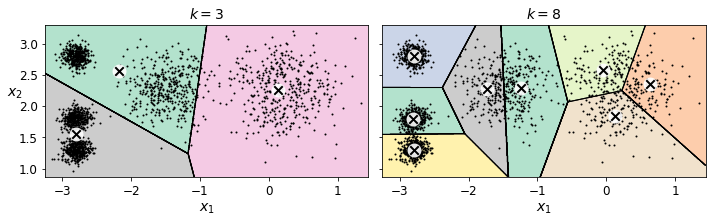

In [67]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Figure 9-7. Bad choices for the number of clusters: when k is too small, separate clusters get merged (left), and when k is too large, some clusters get chopped into multiple pieces (right)

In [68]:
kmeans_k3.inertia_

653.2167190021554

In [69]:
kmeans_k8.inertia_

119.11983416102879

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [70]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


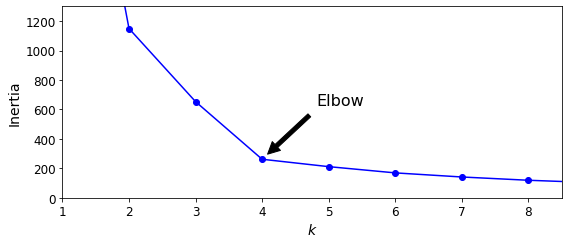

In [71]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

Figure 9-8. When plotting the inertia as a function of the number of clusters k, the curve often contains an inflexion point called the “elbow”

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

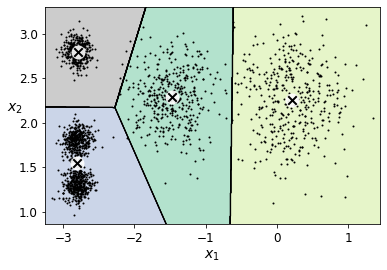

In [72]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [73]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.6359484931112743

In [74]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


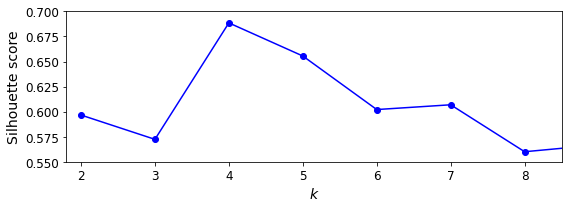

In [75]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Figure 9-9. Selecting the number of clusters k using the silhouette score

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

Saving figure silhouette_analysis_plot


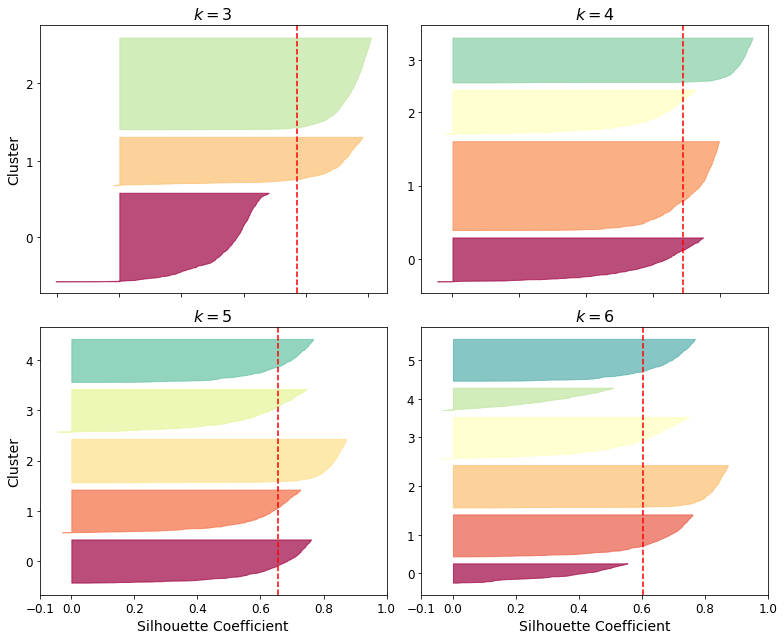

In [76]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

Figure 9-10. Analyzing the silhouette diagrams for various values of k

As you can see, $k=5$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

### Limits of K-Means

Despite its many merits, most notably being fast and scalable, K-Means is not perfect. As we saw, it is necessary to run the algorithm several times to avoid suboptimal solutions, plus you need to specify the number of clusters, which can be quite a hassle. Moreover, K-Means does not behave very well when the clusters have varying sizes, different densities, or nonspherical shapes. For example, Figure 9-11 shows how K-Means clusters a dataset containing three ellipsoidal clusters of different dimensions, densities, and orientations.

In [77]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

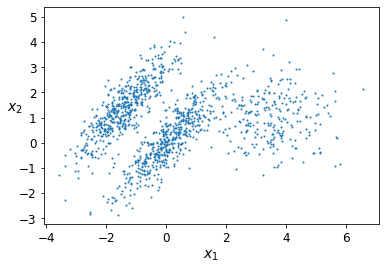

In [78]:
plot_clusters(X)

In [79]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Saving figure bad_kmeans_plot


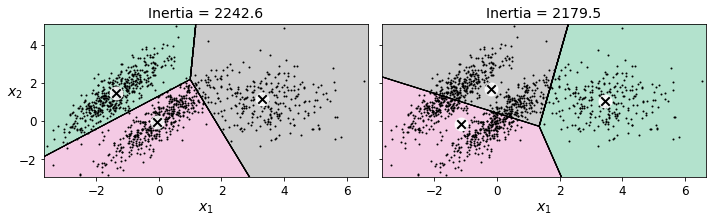

In [80]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

Figure 9-11. K-Means fails to cluster these ellipsoidal blobs properly

As you can see, neither of these solutions is any good. The solution on the left is better, but it still chops off 25% of the middle cluster and assigns it to the cluster on the right. The solution on the right is just terrible, even though its inertia is lower. So, depending on the data, different clustering algorithms may perform better. On these types of elliptical clusters, Gaussian mixture models work great.

>TIP  
>It is important to scale the input features before you run K-Means, or the clusters may be very stretched and K-Means will perform poorly. Scaling the features does not guarantee that all the clusters will be nice and spherical, but it generally improves things.

### Using clustering for image segmentation

*Image segmentation* is the task of partitioning an image into multiple segments. In semantic segmentation, all pixels that are part of the same object type get assigned to the same segment. For example, in a self-driving car’s vision system, all pixels that are part of a pedestrian’s image might be assigned to the “pedestrian” segment (there would be one segment containing all the pedestrians). In instance segmentation, all pixels that are part of the same individual object are assigned to the same segment. In this case there would be a different segment for each pedestrian. The state of the art in semantic or instance segmentation today is achieved using complex architectures based on convolutional neural networks (see Chapter 14). Here, we are going to do something much simpler: color segmentation. We will simply assign pixels to the same segment if they have a similar color. In some applications, this may be sufficient. For example, if you want to analyze satellite images to measure how much total forest area there is in a region, color segmentation may be just fine.

First, use Matplotlib’s `imread()` function to load the image (see the upper-left image in Figure 9-12):

In [81]:
# Download the ladybug image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7f6cf6658520>)

In [82]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [83]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)
kmeans.labels_

array([1, 1, 1, ..., 4, 1, 1], dtype=int32)

In [84]:
kmeans.cluster_centers_[kmeans.labels_].shape

(426400, 3)

In [85]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

In [86]:
segmented_imgs[1].shape

(533, 800, 3)

In [87]:
np.array(segmented_imgs).shape

(5, 533, 800, 3)

Saving figure image_segmentation_diagram


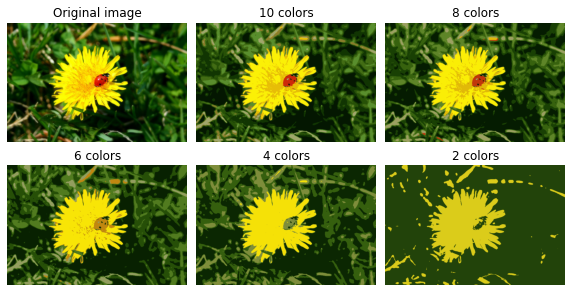

In [88]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

Figure 9-12. Image segmentation using K-Means with various numbers of color clusters

### Using Clustering for Preprocessing

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [89]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [91]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [92]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [93]:
from sklearn.pipeline import Pipeline

In [94]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [95]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

How much did the error rate drop?

In [96]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

How about that? We reduced the error rate by over 28.6%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

In [97]:
from sklearn.model_selection import GridSearchCV

**Warning**: the following cell may take close to 20 minutes to run, or more depending on your hardware.

In [98]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   1.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   1.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   1.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   1.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   1.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   1.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   1.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   1.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   1.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   1.3s
[CV] END ...............................kmeans__n_clusters=5; total time=   1.2s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

Let's see what the best number of clusters is:

In [99]:
grid_clf.best_params_

{'kmeans__n_clusters': 88}

In [100]:
grid_clf.score(X_test, y_test)

0.9822222222222222

With k = 88 clusters, we get a significant accuracy boost, reaching 98.22% accuracy on the test set. Cool! You may want to keep exploring higher values for k, since 99 was the largest value in the range we explored.

### Clustering for Semi-supervised Learning

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [101]:
n_labeled = 50

In [102]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the *representative images*:

In [103]:
k = 50

In [104]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train) #Compute clustering and transform X to cluster-distance space.
#Returns X_newndarray of shape (n_samples, n_clusters)
#X transformed in the new space.
representative_digit_idx = np.argmin(X_digits_dist, axis=0) # the nearest among the 1347 instances, which are the index of centroids
X_representative_digits = X_train[representative_digit_idx]

In [105]:
X_train.shape

(1347, 64)

In [106]:
X_digits_dist.shape

(1347, 50)

In [107]:
X_representative_digits.shape

(50, 64)

Now let's plot these representative images and label them manually:

Saving figure representative_images_diagram


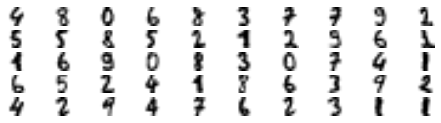

In [108]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

Figure 9-13. Fifty representative digit images (one per cluster)

In [109]:
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [110]:
y_representative_digits = np.array(y_train[representative_digit_idx])
y_representative_digits

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [111]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

Wow! We jumped from 83.3% accuracy to 92.2%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster? This is called *label propagation*:

In [112]:
kmeans.labels_

array([10, 14, 26, ..., 41, 44, 48], dtype=int32)

In [113]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [114]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [115]:
log_reg.score(X_test, y_test)

0.9333333333333333

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 75th percentile closest to the centroid:

In [116]:
X_digits_dist.shape

(1347, 50)

In [117]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [118]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [119]:
y_train_partially_propagated

array([2, 0, 8, ..., 2, 7, 1], dtype=int32)

In [120]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [121]:
log_reg.score(X_test, y_test)

0.9355555555555556

A bit better. With just 50 labeled instances (just 5 examples per class on average!), we got 93.6% performance, which is getting closer to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.9%).

This is because the propagated labels are actually pretty good: their accuracy is close to 96%:

In [122]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9750747756729811

You could now do a few iterations of *active learning*:
1. The model is trained on the labeled instances gathered so far, and this model is used to make predictions on all the unlabeled instances.
2. The instances for which the model is most uncertain (i.e., when its estimated probability is lowest) are given to the expert to be labeled.
3. You iterate this process until the performance improvement stops being worth the labeling effort.  

Other strategies include labeling the instances that would result in the largest model change, or the largest drop in the model’s validation error, or the instances that different models disagree on (e.g., an SVM or a Random Forest). 

Before we move on to Gaussian mixture models, let’s take a look at DBSCAN, another popular clustering algorithm that illustrates a very different approach based on local density estimation. This approach allows the algorithm to identify clusters of arbitrary shapes.

## DBSCAN


This algorithm defines clusters as continuous regions of high density. Here is how it works:

- For each instance, the algorithm counts how many instances are located within a small distance $\epsilon$ (epsilon) from it. This region is called the instance’s $\epsilon$-neighborhood.

- If an instance has at least `min_samples` instances in its $\epsilon$-neighborhood (including itself), then it is considered a core instance. In other words, core instances are those that are located in dense regions.

- All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.

- Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

This algorithm works well if all the clusters are dense enough and if they are well separated by low-density regions. The DBSCAN class in Scikit-Learn is as simple to use as you might expect. Let’s test it on the moons dataset, introduced in Chapter 5:

In [123]:
from sklearn.datasets import make_moons

In [124]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [125]:
from sklearn.cluster import DBSCAN

In [126]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

dbscan contains core instances (808), anomalies and non-core-non-anomalies

In [127]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [128]:
len(dbscan.core_sample_indices_)

808

In [129]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [130]:
dbscan.components_.shape

(808, 2)

In [131]:
dbscan.labels_.shape

(1000,)

In [132]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [133]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [134]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


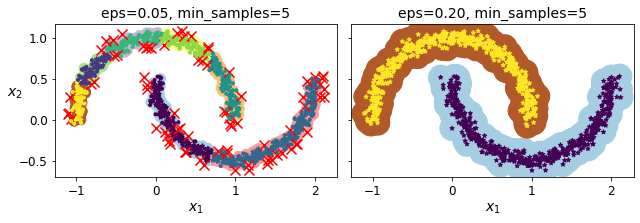

In [135]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


Figure 9-14. DBSCAN clustering using two different neighborhood radiuses

Somewhat surprisingly, the DBSCAN class does not have a `predict()` method, although it has a `fit_predict()` method. In other words, it cannot predict which cluster a new instance belongs to. This implementation decision was made because different classification algorithms can be better for different tasks, so the authors decided to let the user choose which one to use. Moreover, it’s not hard to implement. For example, let’s train a `KNeighborsClassifier`:

In [136]:
dbscan = dbscan2

In [137]:
from sklearn.neighbors import KNeighborsClassifier

In [138]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Note that we only trained the classifier on the core instances, but we could also have chosen to train it on all the instances, or all but the anomalies: this choice depends on the final task.

The decision boundary is represented in Figure 9-15 (the crosses represent the four instances in `X_new`). Notice that since there is no anomaly in the training set, the classifier always chooses a cluster, even when that cluster is far away. It is fairly straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies. To do this, use the `kneighbors()` method of the `KNeighborsClassifier`. Given a set of instances, it returns the distances and the indices of the k nearest neighbors in the training set (two matrices, each with k columns):

In [139]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [140]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Saving figure cluster_classification_plot


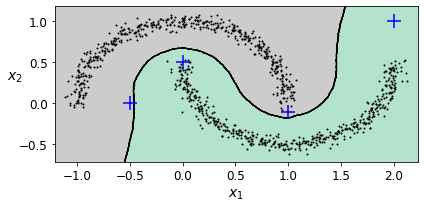

In [141]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

Figure 9-15. Decision boundary between two clusters

In [142]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

In short, DBSCAN is a very simple yet powerful algorithm capable of identifying any number of clusters of any shape. It is robust to outliers, and it has just two hyperparameters (`eps` and `min_samples`). If the density varies significantly across the clusters, however, it can be impossible for it to capture all the clusters properly. Its computational complexity is roughly $O(m \log m)$, making it pretty close to linear with regard to the number of instances, but Scikit-Learn’s implementation can require up to $O(m^2)$ memory if `eps` is large.

## Other Clustering Algorithms

### Spectral Clustering  

This algorithm takes a similarity matrix between the instances and creates a low-dimensional embedding from it (i.e., it reduces its dimensionality), then it uses another clustering algorithm in this low-dimensional space (Scikit-Learn’s implementation uses K-Means.) Spectral clustering can capture complex cluster structures, and it can also be used to cut graphs (e.g., to identify clusters of friends on a social network). It does not scale well to large numbers of instances, and it does not behave well when the clusters have very different sizes.

In [143]:
from sklearn.cluster import SpectralClustering

In [144]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [145]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [146]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [147]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

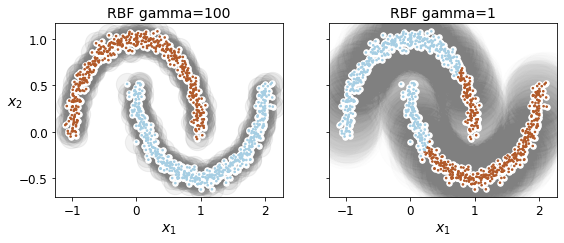

In [148]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### Agglomerative Clustering  

A hierarchy of clusters is built from the bottom up. Think of many tiny bubbles floating on water and gradually attaching to each other until there’s one big group of bubbles. Similarly, at each iteration, agglomerative clustering connects the nearest pair of clusters (starting with individual instances). If you drew a tree with a branch for every pair of clusters that merged, you would get a binary tree of clusters, where the leaves are the individual instances. This approach scales very well to large numbers of instances or clusters. It can capture clusters of various shapes, it produces a flexible and informative cluster tree instead of forcing you to choose a particular cluster scale, and it can be used with any pairwise distance. It can scale nicely to large numbers of instances if you provide a connectivity matrix, which is a sparse m × m matrix that indicates which pairs of instances are neighbors (e.g., returned by `sklearn.neighbors.kneighbors_graph()`). Without a connectivity matrix, the algorithm does not scale well to large datasets.

In [149]:
from sklearn.cluster import AgglomerativeClustering

In [150]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [151]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [152]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [153]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

## Gaussian Mixtures

A *Gaussian mixture model (GMM)* is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. All the instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid. Each cluster can have a different ellipsoidal shape, size, density, and orientation, just like in Figure 9-11. When you observe an instance, you know it was generated from one of the Gaussian distributions, but you are not told which one, and you do not know what the parameters of these distributions are.

There are several GMM variants. In the simplest variant, implemented in the `GaussianMixture` class, you must know in advance the number k of Gaussian distributions. The dataset X is assumed to have been generated through the following probabilistic process:

- For each instance, a cluster is picked randomly from among k clusters. The probability of choosing the $j^{th}$ cluster is defined by the cluster’s weight, $\phi^{(j)}$. The index of the cluster chosen for the $i^{th}$ instance is noted $z^{(i)}$.

- If $z^{(i)}=j$, meaning the $i^{th}$ instance has been assigned to the $j^{th}$ cluster, the location $x^{(i)}$ of this instance is sampled randomly from the Gaussian distribution with mean $\boldsymbol\mu^{(j)}$ and covariance matrix $\boldsymbol\Sigma^{(j)}$. This is noted $x^{(i)}\sim N(\boldsymbol\mu^{(j)}, \boldsymbol\Sigma^{(j)})$.

This generative process can be represented as a graphical model. Figure 9-16 represents the structure of the conditional dependencies between random variables.

<img src="./chapters/9/9.16.png" width = 600>
<div style="text-align:center"> Figure 9-16. A graphical representation of a Gaussian mixture model, including its parameters (squares), random variables (circles), and their conditional dependencies (solid arrows) </div>

Here is how to interpret the figure:

- The circles represent random variables.

- The squares represent fixed values (i.e., parameters of the model).

- The large rectangles are called plates. They indicate that their content is repeated several times.

- The number at the bottom right of each plate indicates how many times its content is repeated. So, there are $m$ random variables $z^{(i)}$ (from $z^{(1)}$ to $z^{(m)}$) and $m$ random variables $x^{(i)}$. There are also $k$ means $\boldsymbol\mu^{(j)}$ and $k$ covariance matrices $\boldsymbol\Sigma^{(j)}$. Lastly, there is just one weight vector $\phi$ (containing all the weights $\phi^{(1)}$ to $\phi^{(k)}$).

- Each variable $z^{(i)}$ is drawn from the categorical distribution with weights $\boldsymbol\phi$. Each variable $x^{(i)}$ is drawn from the normal distribution, with the mean and covariance matrix defined by its cluster $z^{(i)}$.

- The solid arrows represent conditional dependencies. For example, the probability distribution for each random variable $z^{(i)}$ depends on the weight vector $\boldsymbol\phi$. Note that when an arrow crosses a plate boundary, it means that it applies to all the repetitions of that plate. For example, the weight vector $\boldsymbol\phi$ conditions the probability distributions of all the random variables $x^{(1)}$ to $x^{(m)}$.

- The squiggly arrow from $z^{(i)}$ to $x^{(i)}$ represents a switch: depending on the value of $z^{(i)}$, the instance $x^{(i)}$ will be sampled from a different Gaussian distribution. For example, if $z^{(i)}=j$, then $x^{(i)}\sim N(\boldsymbol\mu^{(j)}, \boldsymbol\Sigma^{(j)})$.

- Shaded nodes indicate that the value is known. So, in this case, only the random variables $x^{(i)}$ have known values: they are called observed variables. The unknown random variables $z^{(i)}$ are called latent variables.

So, what can you do with such a model? Well, given the dataset $\mathbf X$, you typically want to start by estimating the weights $\boldsymbol\phi$ and all the distribution parameters $\boldsymbol\mu^{(1)}$ to $\boldsymbol\mu^{(k)}$ and $\boldsymbol\Sigma^{(1)}$ to $\boldsymbol\Sigma^{(k)}$. Scikit-Learn’s `GaussianMixture` class makes this super easy:

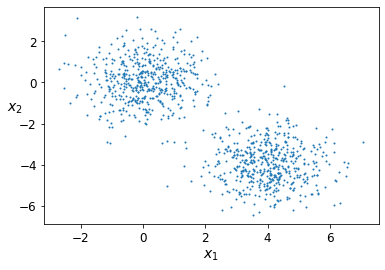

In [240]:
from sklearn.datasets import make_blobs
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
plot_clusters(X1)

In [243]:
X1.shape, y1.shape

((1000, 2), (1000,))

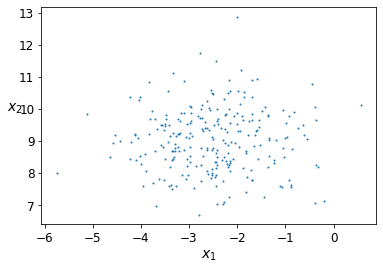

In [245]:
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
plot_clusters(X2)

In [156]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]
X

array([[ 0.81672911,  1.32719052],
       [ 0.28671649,  1.30485269],
       [-1.89804675, -0.00869803],
       ...,
       [ 3.00543883,  1.09616027],
       [ 4.63362519,  1.76621916],
       [ 3.58847848,  0.24127634]])

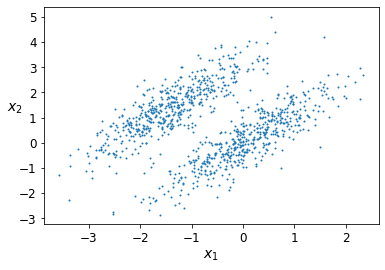

In [157]:
plot_clusters(X1)

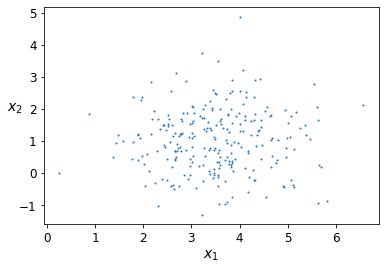

In [158]:
plot_clusters(X2)

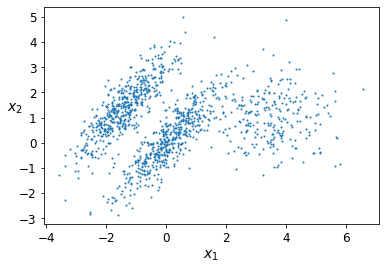

In [159]:
plot_clusters(X)

Let's train a Gaussian mixture model on the previous dataset:

In [160]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [161]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [162]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [163]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

Indeed, the weights that were used to generate the data were 0.2, 0.4, and 0.4; and similarly, the means and covariance matrices were very close to those found by the algorithm. But how? This class relies on the *Expectation-Maximization (EM)* algorithm, which has many similarities with the K-Means algorithm: it also initializes the cluster parameters randomly, then it repeats two steps until convergence, first assigning instances to clusters (this is called the *expectation step*) and then updating the clusters (this is called the *maximization step*). Sounds familiar, right? In the context of clustering, you can think of EM as a generalization of K-Means that not only finds the cluster centers ($\boldsymbol\mu^{(1)}$ to $\boldsymbol\mu^{(k)}$), but also their size, shape, and orientation ($\boldsymbol\Sigma^{(1)}$ to $\boldsymbol\Sigma^{(k)}$), as well as their relative weights ($\phi^{(1)}$ to $\phi^{(k)}$). Unlike K-Means, though, EM uses soft cluster assignments, not hard assignments. For each instance, during the expectation step, the algorithm estimates the probability that it belongs to each cluster (based on the current cluster parameters). Then, during the maximization step, each cluster is updated using all the instances in the dataset, with each instance weighted by the estimated probability that it belongs to that cluster. These probabilities are called the *responsibilities* of the clusters for the instances. During the maximization step, each cluster’s update will mostly be impacted by the instances it is most responsible for.

Did the algorithm actually converge?

In [164]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [165]:
gm.n_iter_

4

Now that you have an estimate of the location, size, shape, orientation, and relative weight of each cluster, the model can easily assign each instance to the most likely cluster (hard clustering) or estimate the probability that it belongs to a particular cluster (soft clustering). You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [166]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2])

In [167]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

This is a *generative model*, so you can sample new instances from it (and get their labels):

In [168]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [169]:
y_new

array([0, 0, 1, 2, 2, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method: The greater the score, the higher the density:

In [170]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [171]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.999999999921502

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [172]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure gaussian_mixtures_plot


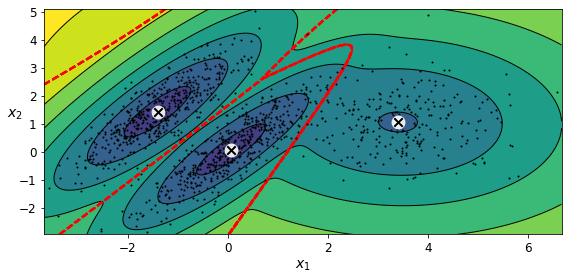

In [173]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

Figure 9-17. Cluster means, decision boundaries, and density contours of a trained Gaussian mixture model

Nice! The algorithm clearly found an excellent solution. Of course, we made its task easy by generating the data using a set of 2D Gaussian distributions (unfortunately, real-life data is not always so Gaussian and low-dimensional). We also gave the algorithm the correct number of clusters. When there are many dimensions, or many clusters, or few instances, EM can struggle to converge to the optimal solution. You might need to reduce the difficulty of the task by limiting the number of parameters that the algorithm has to learn. One way to do this is to limit the range of shapes and orientations that the clusters can have. This can be achieved by imposing constraints on the covariance matrices. To do this, set the `covariance_type` hyperparameter to one of the following values:


* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

In [174]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [175]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


Saving figure covariance_type_plot


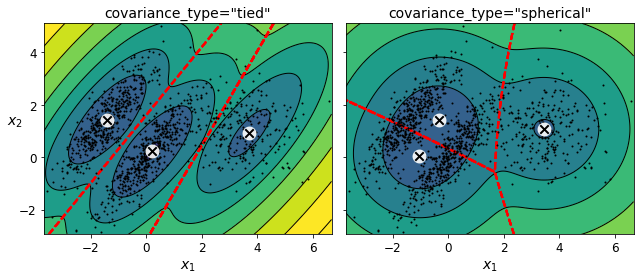

In [176]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

Figure 9-18. Gaussian mixtures for tied clusters (left) and spherical clusters (right)

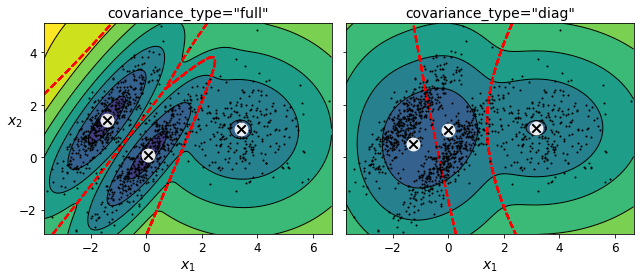

In [177]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [178]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]
densities

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

Saving figure mixture_anomaly_detection_plot


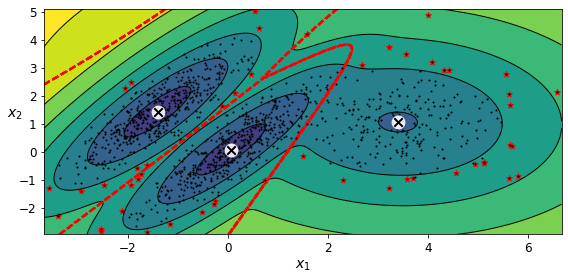

In [179]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

Figure 9-19. Anomaly detection using a Gaussian mixture model

A closely related task is *novelty detection*: it differs from anomaly detection in that the algorithm is assumed to be trained on a “clean” dataset, uncontaminated by outliers, whereas anomaly detection does not make this assumption. Indeed, outlier detection is often used to clean up a dataset.

Just like K-Means, the GaussianMixture algorithm requires you to specify the number of clusters. So, how can you find it?

### Selecting the Number of Clusters

We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the *Bayesian Information Criterion (BIC)* or the *Akaike Information Criterion (AIC)*:

*Equation 9-1. Bayesian information criterion (BIC) and Akaike information criterion (AIC)*  


${BIC} = p\;{\ln(m) - 2\ln({\hat L})}$

${AIC} = 2p - 2\ln(\hat L)$

* $m$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data). They often end up selecting the same model. When they differ, the model selected by the BIC tends to be simpler (fewer parameters) than the one selected by the AIC, but tends to not fit the data quite as well (this is especially true for larger datasets).

### Likelihood Function  

The terms “probability” and “likelihood” are often used interchangeably in the English language, but they have very different meanings in statistics. Given a statistical model with some parameters $\boldsymbol\theta$, the word “probability” is used to describe how plausible a future outcome $\mathbf x$ is (knowing the parameter values $\boldsymbol\theta$), while the word “likelihood” is used to describe how plausible a particular set of parameter values $\boldsymbol\theta$ are, after the outcome $\mathbf x$ is known.

Consider a 1D mixture model of two Gaussian distributions centered at –4 and +1. For simplicity, this toy model has a single parameter $\theta$ that controls the standard deviations of both distributions. The top-left contour plot in Figure 9-20 shows the entire model $f(x; \theta)$ as a function of both x and $\theta$. To estimate the probability distribution of a future outcome $x$, you need to set the model parameter $\theta$. For example, if you set $\theta$ to 1.3 (the horizontal line), you get the probability density function $f(x; \theta=1.3)$ shown in the lower-left plot. Say you want to estimate the probability that $x$ will fall between –2 and +2. You must calculate the integral of the PDF on this range (i.e., the surface of the shaded region). But what if you don’t know $\theta$, and instead if you have observed a single instance $x=2.5$ (the vertical line in the upper-left plot)? In this case, you get the likelihood function $\mathscr L(\theta|x=2.5)=f(x=2.5; \theta)$, represented in the upper-right plot.

In [180]:
from scipy.stats import norm

In [181]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

Saving figure likelihood_function_plot


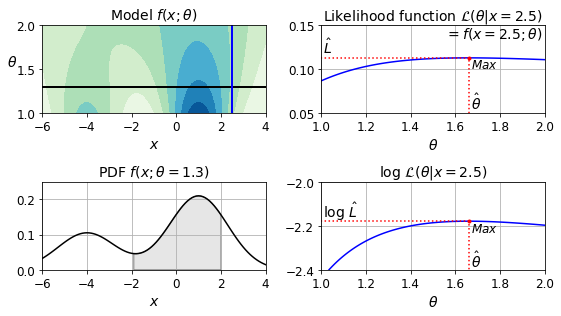

In [182]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

save_fig("likelihood_function_plot")
plt.show()

Figure 9-20. A model’s parametric function (top left), and some derived functions: a PDF (lower left), a likelihood function (top right), and a log likelihood function (lower right)

In short, the PDF is a function of $x$ (with $\theta$ fixed), while the likelihood function is a function of $\theta$ (with $x$ fixed). It is important to understand that the likelihood function is not a probability distribution: if you integrate a probability distribution over all possible values of $x$, you always get 1; but if you integrate the likelihood function over all possible values of $\theta$, the result can be any positive value.

Given a dataset $\mathbf X$, a common task is to try to estimate the most likely values for the model parameters. To do this, you must find the values that maximize the likelihood function, given $\mathbf X$. In this example, if you have observed a single instance $x=2.5$, the *maximum likelihood estimate (MLE)* of θ is $\hat\theta=1.5$. If a prior probability distribution $g$ over $\theta$ exists, it is possible to take it into account by maximizing $\mathscr L(\theta|x)g(\theta)$ rather than just maximizing $\mathscr L(\theta|x)$. This is called *maximum a-posteriori (MAP)* estimation. Since MAP constrains the parameter values, you can think of it as a regularized version of MLE.

Notice that maximizing the likelihood function is equivalent to maximizing its logarithm (represented in the lower-righthand plot in Figure 9-20). Indeed the logarithm is a strictly increasing function, so if $\theta$ maximizes the log likelihood, it also maximizes the likelihood. It turns out that it is generally easier to maximize the log likelihood. For example, if you observed several independent instances $x^{(1)}$ to $x^{(m)}$, you would need to find the value of $\theta$ that maximizes the product of the individual likelihood functions. But it is equivalent, and much simpler, to maximize the sum (not the product) of the log likelihood functions, thanks to the magic of the logarithm which converts products into sums: $\log(ab)=\log(a)+\log(b)$.

Once you have estimated $\hat\theta$, the value of $\theta$ that maximizes the likelihood function, then you are ready to compute $\hat L=\mathscr L(\hat\theta,\mathbf X)$, which is the value used to compute the AIC and BIC; you can think of it as a measure of how well the model fits the data.

To compute the BIC and AIC, call the `bic()` and `aic()` methods:

In [183]:
gm.bic(X)

8189.747000497188

In [184]:
gm.aic(X)

8102.52172038215

We could compute the BIC manually like this:

In [185]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [186]:
bic, aic

(8189.747000497188, 8102.52172038215)

In [187]:
n_params

17

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [188]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [189]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Saving figure aic_bic_vs_k_plot


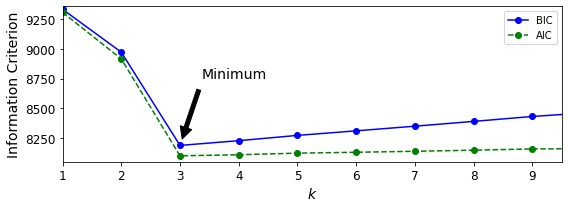

In [190]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("aic_bic_vs_k_plot")
plt.show()

Figure 9-21. AIC and BIC for different numbers of clusters k

Figure 9-21 shows the BIC for different numbers of clusters k. As you can see, both the BIC and the AIC are lowest when k=3, so it is most likely the best choice. Note that we could also search for the best value for the `covariance_type` hyperparameter. For example, if it is `"spherical"` rather than `"full"`, then the model has significantly fewer parameters to learn, but it does not fit the data as well.

Let's search for best combination of values for both the number of clusters and the `covariance_type` hyperparameter:

In [191]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [192]:
best_k

3

In [193]:
best_covariance_type

'full'

### Variational Bayesian Gaussian Mixtures

Rather than manually searching for the optimal number of clusters, you can use the `BayesianGaussianMixture` class, which is capable of giving weights equal (or close) to zero to unnecessary clusters. Set the number of clusters `n_components` to a value that you have good reason to believe is greater than the optimal number of clusters (this assumes some minimal knowledge about the problem at hand), and the algorithm will eliminate the unnecessary clusters automatically. For example, let’s set the number of clusters to 10 and see what happens:

In [194]:
from sklearn.mixture import BayesianGaussianMixture

In [195]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

The algorithm automatically detected that only 3 components are needed:

In [196]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

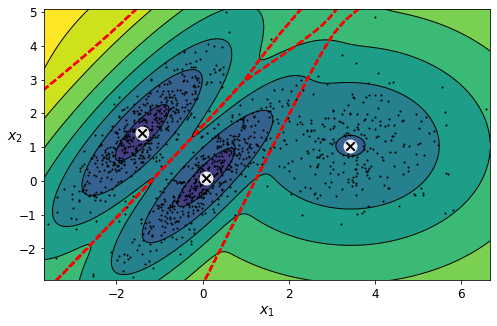

In [197]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In this model, the cluster parameters (including the weights, means, and covariance matrices) are not treated as fixed model parameters anymore, but as latent random variables, like the cluster assignments (see Figure 9-22). So $\mathbf z$ now includes both the cluster parameters and the cluster assignments.

The Beta distribution is commonly used to model random variables whose values lie within a fixed range. In this case, the range is from 0 to 1. The Stick-Breaking Process (SBP) is best explained through an example: suppose $\Phi=[0.3, 0.6, 0.5,\cdots]$, then 30% of the instances will be assigned to cluster 0, then 60% of the remaining instances will be assigned to cluster 1, then 50% of the remaining instances will be assigned to cluster 2, and so on. This process is a good model for datasets where new instances are more likely to join large clusters than small clusters (e.g., people are more likely to move to larger cities). If the concentration $\alpha$ is high, then $\Phi$ values will likely be close to 0, and the SBP generate many clusters. Conversely, if the concentration is low, then $\Phi$ values will likely be close to 1, and there will be few clusters. Finally, the Wishart distribution is used to sample covariance matrices: the parameters d and V control the distribution of cluster shapes.

<img src="./chapters/9/9.22.png" width = 600>
<div style="text-align:left"> Figure 9-22. Bayesian Gaussian mixture model </div>

Prior knowledge about the latent variables $\mathbf z$ can be encoded in a probability distribution $p(\mathbf z)$ called the prior. For example, we may have a prior belief that the clusters are likely to be few (low concentration), or conversely, that they are likely to be plentiful (high concentration). This prior belief about the number of clusters can be adjusted using the `weight_concentration_prior` hyperparameter. Setting it to 0.01 or 10,000 gives very different clusterings (see Figure 9-23). The more data we have, however, the less the priors matter. In fact, to plot diagrams with such large differences, you must use very strong priors and little data.

In [198]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [199]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [200]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

Saving figure mixture_concentration_prior_plot


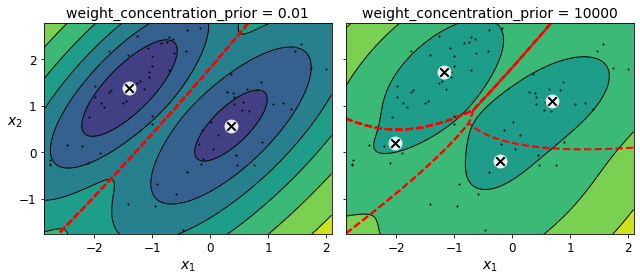

In [201]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

Figure 9-23. Using different concentration priors on the same data results in different numbers of clusters

Note: the fact that you see only 3 regions in the right plot although there are 4 centroids is not a bug. The weight of the top-right cluster is much larger than the weight of the lower-right cluster, so the probability that any given point in this region belongs to the top right cluster is greater than the probability that it belongs to the lower-right cluster.

Bayes’ theorem (Equation 9-2) tells us how to update the probability distribution over the latent variables after we observe some data $\mathbf X$. It computes the posterior distribution $p(\mathbf z|\mathbf X)$, which is the conditional probability of $\mathbf z$ given $\mathbf X$.

*Equation 9-2. Bayes’ theorem*  

$$p(\mathbf z|\mathbf X)=\frac{p(\mathbf X|\mathbf z)p(\mathbf z)}{p(\mathbf X)}$$

Unfortunately, in a Gaussian mixture model (and many other problems), the denominator $p(\mathbf x)$ is intractable, as it requires integrating over all the possible values of $\mathbf z$ (Equation 9-3), which would require considering all possible combinations of cluster parameters and cluster assignments.

*Equation 9-3. The evidence $p(X)$ is often intractable*

$$p(\mathbf X)=\int p(\mathbf X|\mathbf z)p(\mathbf z)d\mathbf z$$

This intractability is one of the central problems in Bayesian statistics, and there are several approaches to solving it. One of them is variational inference, which picks a family of distributions $q(\mathbf z; \lambda)$ with its own variational parameters $\lambda$ (lambda), then optimizes these parameters to make $q(\mathbf z)$ a good approximation of $p(\mathbf z|\mathbf X)$. This is achieved by finding the value of $\lambda$ that minimizes the KL divergence from $q(\mathbf z)$ to $p(\mathbf z|\mathbf X)$, noted $D_{KL}(q‖p)$. The KL divergence equation is shown in Equation 9-4, and it can be rewritten as the log of the evidence ($\log p(\mathbf X)$) minus the *evidence lower bound (ELBO)*. Since the log of the evidence does not depend on q, it is a constant term, so minimizing the KL divergence just requires maximizing the ELBO.

*Equation 9-4. KL divergence from $q(\mathbf z)$ to $p(\mathbf z|\mathbf X)$*

$$\begin{align}
D_{KL}(q \lVert p)&=\mathbb E_q\left[\log\frac{q(\mathbf z)}{p(\mathbf z|\mathbf X)}\right]\\
&=\mathbb E_q\left[\log q(\mathbf z)-\log p(\mathbf z|\mathbf X)\right]\\
&=\mathbb E_q\left[\log q(\mathbf z)-\log \frac{p(\mathbf z,\mathbf X)}{p(\mathbf X)}\right]\\
&=\mathbb E_q\left[\log q(\mathbf z)-\log p(\mathbf z,\mathbf X)+ \log p(\mathbf X)\right]\\
&=\mathbb E_q\left[\log q(\mathbf z)\right]-\mathbb E_q\left[\log p(\mathbf z,\mathbf X)\right]+ \mathbb E_q\left[\log p(\mathbf X)\right]\\
&=\mathbb E_q\left[\log p(\mathbf X)\right] - \left(\mathbb E_q\left[\log p(\mathbf z,\mathbf X)\right] - \mathbb E_q\left[\log q(\mathbf z)\right]\right)\\
&=\mathbb E_q\left[\log p(\mathbf X)\right] - \text{ELBO}\\
&\text{where ELBO} = \mathbb E_q\left[\log p(\mathbf z,\mathbf X)\right] - \mathbb E_q\left[\log q(\mathbf z)\right]\\
\end{align}$$

In practice, there are different techniques to maximize the ELBO. In *mean field variational inference*, it is necessary to pick the family of distributions $q(\mathbf z; \lambda)$ and the prior $p(\mathbf z)$ very carefully to ensure that the equation for the ELBO simplifies to a form that can be computed. Unfortunately, there is no general way to do this. Picking the right family of distributions and the right prior depends on the task and requires some mathematical skills. For example, the distributions and lower-bound equations used in Scikit-Learn’s `BayesianGaussianMixture` class are presented in the [documentation](https://scikit-learn.org/stable/modules/mixture.html). From these equations it is possible to derive update equations for the cluster parameters and assignment variables: these are then used very much like in the Expectation-Maximization algorithm. In fact, the computational complexity of the `BayesianGaussianMixture` class is similar to that of the `GaussianMixture` class (but generally significantly slower). A simpler approach to maximizing the ELBO is called *black box stochastic variational inference (BBSVI)*: at each iteration, a few samples are drawn from $q$, and they are used to estimate the gradients of the ELBO with regard to the variational parameters $\lambda$, which are then used in a gradient ascent step. This approach makes it possible to use Bayesian inference with any kind of model (provided it is differentiable), even deep neural networks; using Bayesian inference with deep neural networks is called *Bayesian Deep Learning*.

Gaussian mixture models work great on clusters with ellipsoidal shapes, but if you try to fit a dataset with different shapes, you may have bad surprises. For example, let’s see what happens if we use a Bayesian Gaussian mixture model to cluster the moons dataset (see Figure 9-24).

In [202]:
from sklearn.datasets import make_moons
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [203]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

Saving figure moons_vs_bgm_plot


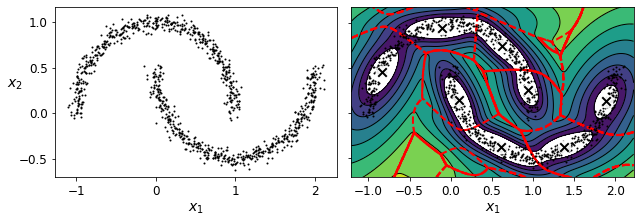

In [204]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

Figure 9-24. Fitting a Gaussian mixture to nonellipsoidal clusters

Oops! The algorithm desperately searched for ellipsoids, so it found eight different clusters instead of two. The density estimation is not too bad, so this model could perhaps be used for anomaly detection, but it failed to identify the two moons. Let’s now look at a few clustering algorithms capable of dealing with arbitrarily shaped clusters.

## Exercise solutions

1. How would you define clustering? Can you name a few clustering algorithms?

>In Machine Learning, clustering is the unsupervised task of grouping similar instances together. The notion of similarity depends on the task at hand: for example, in some cases two nearby instances will be considered similar, while in others similar instances may be far apart as long as they belong to the same densely packed group. Popular clustering algorithms include K-Means, DBSCAN, agglomerative clustering, BIRCH, Mean-Shift, affinity propagation, and spectral clustering.

2. What are some of the main applications of clustering algorithms?

>The main applications of clustering algorithms include data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, anomaly detection, and novelty detection.

3. Describe two techniques to select the right number of clusters when using K-Means.

>The **elbow rule** is a simple technique to select the number of clusters when using K-Means: just plot the inertia (the mean squared distance from each instance to its nearest centroid) as a function of the number of clusters, and find the point in the curve where the inertia stops dropping fast (the “elbow”). This is generally close to the optimal number of clusters. Another approach is to plot the **silhouette score** as a function of the number of clusters. There will often be a peak, and the optimal number of clusters is generally nearby. The silhouette score is the mean silhouette coefficient over all instances. This coefficient varies from +1 for instances that are well inside their cluster and far from other clusters, to –1 for instances that are very close to another cluster. You may also plot the **silhouette diagrams** and perform a more thorough analysis.


4. What is label propagation? Why would you implement it, and how?

>Labeling a dataset is costly and time-consuming. Therefore, it is common to have plenty of unlabeled instances, but few labeled instances. **Label propagation** is a technique that consists in copying some (or all) of the labels from the labeled instances to similar unlabeled instances. This can greatly extend the number of labeled instances, and thereby allow a supervised algorithm to reach better performance (this is a form of semi-supervised learning). One approach is to use a clustering algorithm such as K-Means on all the instances, then for each cluster find the most common label or the label of the most representative instance (i.e., the one closest to the centroid) and propagate it to the unlabeled instances in the same cluster.

5. Can you name two clustering algorithms that can scale to large datasets? And two that look for regions of high density?

>**K-Means** and **BIRCH** scale well to large datasets. DBSCAN and Mean-Shift look for regions of high density.

6. Can you think of a use case where active learning would be useful? How would you implement it?

>Active learning is useful whenever you have plenty of unlabeled instances but labeling is costly. In this case (which is very common), rather than randomly selecting instances to label, it is often preferable to perform **active learning**, where human experts interact with the learning algorithm, providing labels for specific instances when the algorithm requests them. A common approach is uncertainty sampling (see the description in “Active Learning”).

7. What is the difference between anomaly detection and novelty detection?

>Many people use the terms anomaly detection and novelty detection interchangeably, but they are not exactly the same. In anomaly detection, the algorithm is trained on a dataset that may contain outliers, and the goal is typically to identify these outliers (within the training set), as well as outliers among new instances. In novelty detection, the algorithm is trained on a dataset that is presumed to be “clean,” and the objective is to detect novelties strictly among new instances. Some algorithms work best for anomaly detection (e.g., Isolation Forest), while others are better suited for novelty detection (e.g., one-class SVM).

8. What is a Gaussian mixture? What tasks can you use it for?

>A **Gaussian mixture model (GMM)** is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. In other words, the assumption is that the data is grouped into a finite number of clusters, each with an ellipsoidal shape (but the clusters may have different ellipsoidal shapes, sizes, orientations, and densities), and we don’t know which cluster each instance belongs to. This model is useful for density estimation, clustering, and anomaly detection.

9. Can you name two techniques to find the right number of clusters when using a Gaussian mixture model?

>One way to find the right number of clusters when using a Gaussian mixture model is to plot the **Bayesian information criterion (BIC)** or the **Akaike information criterion (AIC)** as a function of the number of clusters, then choose the number of clusters that minimizes the BIC or AIC. Another technique is to use a **Bayesian Gaussian mixture model**, which automatically selects the number of clusters.

10. Cluster the Olivetti Faces Dataset

The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the `sklearn.datasets.fetch_olivetti_faces()` function, then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set. Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter). Visualize the clusters: do you see similar faces in each cluster?


In [205]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [247]:
olivetti.data.shape, olivetti.target.shape

((400, 4096), (400,))

*Exercise: Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.*

In [207]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target)) # The next() function returns the next item in an iterator.
# StratifiedShuffleSplit.split: Generate indices to split data into training and test set.
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [208]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


To speed things up, we'll reduce the data's dimensionality using PCA:

In [209]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

*Exercise: Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter).*

In [210]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


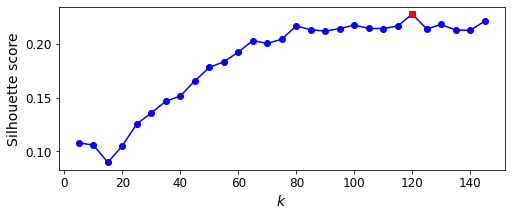

In [211]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [212]:
best_k

120

It looks like the best number of clusters is quite high, at 120. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

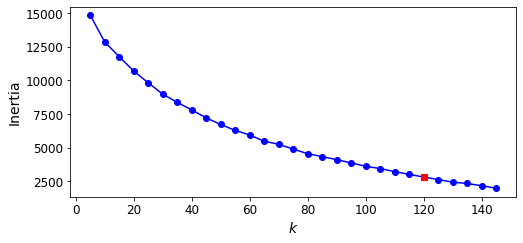

In [213]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The optimal number of clusters is not clear on this inertia diagram, as there is no obvious elbow, so let's stick with k=100.

In [214]:
best_index

23

In [215]:
best_model = kmeans_per_k[best_index]

In [250]:
np.unique(best_model.labels_), np.unique(best_model.labels_).shape

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119], dtype=int32),
 (120,))

In [248]:
best_model.labels_.shape

(280,)

*Exercise: Visualize the clusters: do you see similar faces in each cluster?*

Cluster 0


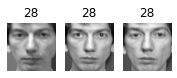

Cluster 1


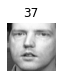

Cluster 2


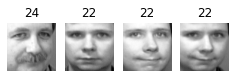

Cluster 3


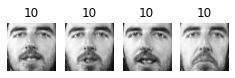

Cluster 4


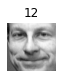

Cluster 5


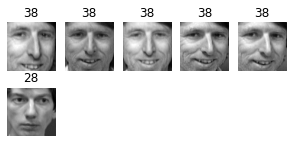

Cluster 6


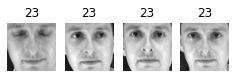

Cluster 7


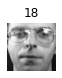

Cluster 8


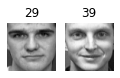

Cluster 9


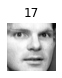

Cluster 10


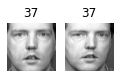

Cluster 11


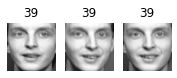

Cluster 12


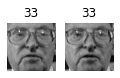

Cluster 13


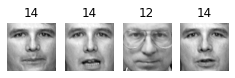

Cluster 14


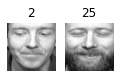

Cluster 15


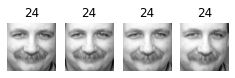

Cluster 16


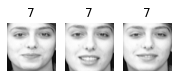

Cluster 17


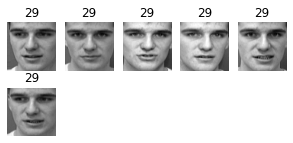

Cluster 18


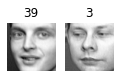

Cluster 19


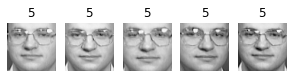

Cluster 20


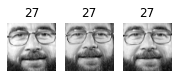

Cluster 21


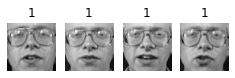

Cluster 22


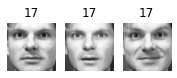

Cluster 23


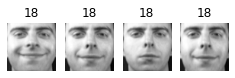

Cluster 24


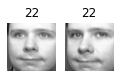

Cluster 25


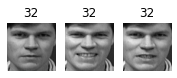

Cluster 26


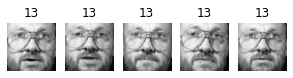

Cluster 27


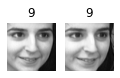

Cluster 28


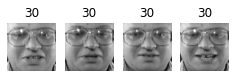

Cluster 29


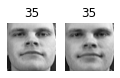

Cluster 30


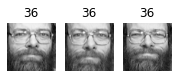

Cluster 31


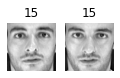

Cluster 32


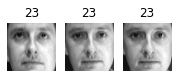

Cluster 33


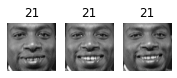

Cluster 34


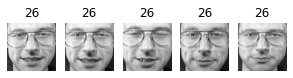

Cluster 35


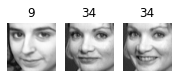

Cluster 36


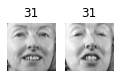

Cluster 37


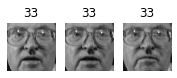

Cluster 38


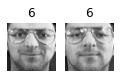

Cluster 39


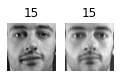

Cluster 40


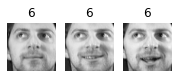

Cluster 41


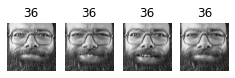

Cluster 42


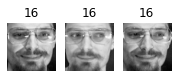

Cluster 43


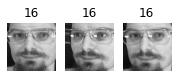

Cluster 44


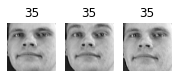

Cluster 45


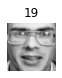

Cluster 46


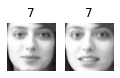

Cluster 47


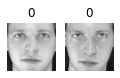

Cluster 48


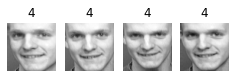

Cluster 49


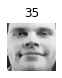

Cluster 50


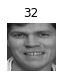

Cluster 51


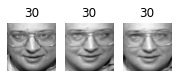

Cluster 52


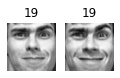

Cluster 53


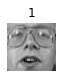

Cluster 54


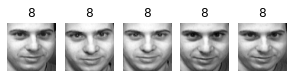

Cluster 55


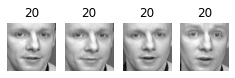

Cluster 56


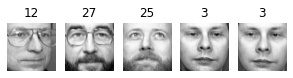

Cluster 57


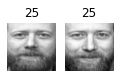

Cluster 58


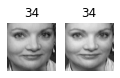

Cluster 59


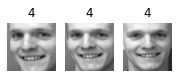

Cluster 60


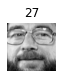

Cluster 61


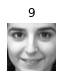

Cluster 62


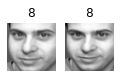

Cluster 63


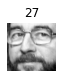

Cluster 64


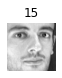

Cluster 65


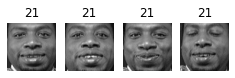

Cluster 66


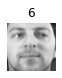

Cluster 67


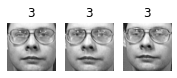

Cluster 68


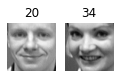

Cluster 69


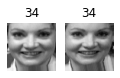

Cluster 70


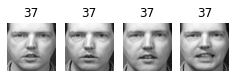

Cluster 71


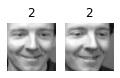

Cluster 72


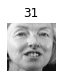

Cluster 73


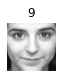

Cluster 74


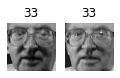

Cluster 75


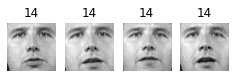

Cluster 76


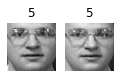

Cluster 77


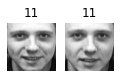

Cluster 78


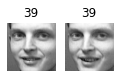

Cluster 79


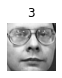

Cluster 80


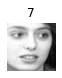

Cluster 81


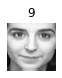

Cluster 82


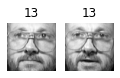

Cluster 83


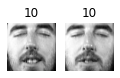

Cluster 84


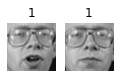

Cluster 85


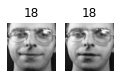

Cluster 86


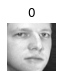

Cluster 87


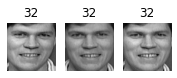

Cluster 88


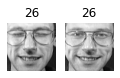

Cluster 89


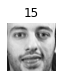

Cluster 90


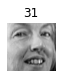

Cluster 91


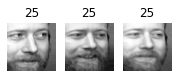

Cluster 92


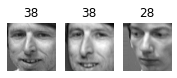

Cluster 93


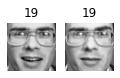

Cluster 94


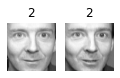

Cluster 95


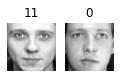

Cluster 96


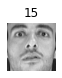

Cluster 97


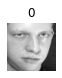

Cluster 98


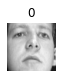

Cluster 99


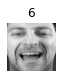

Cluster 100


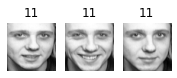

Cluster 101


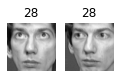

Cluster 102


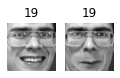

Cluster 103


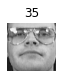

Cluster 104


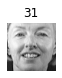

Cluster 105


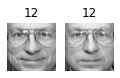

Cluster 106


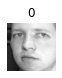

Cluster 107


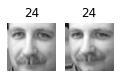

Cluster 108


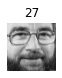

Cluster 109


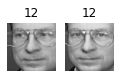

Cluster 110


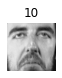

Cluster 111


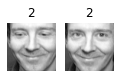

Cluster 112


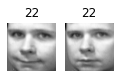

Cluster 113


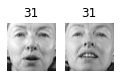

Cluster 114


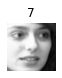

Cluster 115


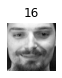

Cluster 116


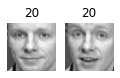

Cluster 117


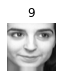

Cluster 118


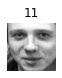

Cluster 119


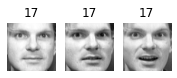

In [216]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

About 2 out of 3 clusters are useful: that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way may be too imprecise to be directly useful when training a model (as we will see below), but it can be tremendously useful when labeling images in a new dataset: it will usually make labelling much faster.

11. Using Clustering as Preprocessing for Classification

Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set. Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set. Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach? What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?

*Exercise: Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.*

In [217]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.9

*Exercise: Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set.*

In [218]:
best_model

KMeans(n_clusters=120, random_state=42)

In [219]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.7

In [220]:
X_train_pca.shape

(280, 199)

In [221]:
X_train_reduced.shape

(280, 120)

Yikes! That's not better at all! Let's see if tuning the number of clusters helps.

*Exercise: Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach?*

We could use a `GridSearchCV` like we did earlier in this notebook, but since we already have a validation set, we don't need K-fold cross-validation, and we're only exploring a single hyperparameter, so it's simpler to just run a loop manually:

In [222]:
for n_clusters in k_range:
    print(n_clusters)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145


In [223]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.3875
10 0.575
15 0.6
20 0.6625
25 0.6625
30 0.6625
35 0.675
40 0.75
45 0.7375
50 0.725
55 0.7125
60 0.7125
65 0.7375
70 0.7375
75 0.7375
80 0.7875
85 0.7625
90 0.75
95 0.7125
100 0.775
105 0.75
110 0.725
115 0.7625
120 0.7
125 0.75
130 0.725
135 0.7375
140 0.75
145 0.6875


Oh well, even by tuning the number of clusters, we never get beyond 80% accuracy. Looks like the distances to the cluster centroids are not as informative as the original images.

*Exercise: What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?*

In [224]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [225]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.8125

That's a bit better, but still worse than without the cluster features. The clusters are not useful to directly train a classifier in this case (but they can still help when labelling new training instances).

12. A Gaussian Mixture Model for the Olivetti Faces Dataset

Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset’s dimensionality (e.g., use PCA, preserving 99% of the variance). Use the model to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will need to use its `inverse_transform()` method). Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the `score_samples()` method for normal images and for anomalies).


In [226]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*Exercise: Use the model to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will need to use its `inverse_transform()` method).*

In [227]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

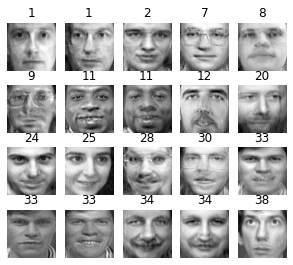

In [228]:
plot_faces(gen_faces, y_gen_faces)

*Exercise: Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the `score_samples()` method for normal images and for anomalies).*

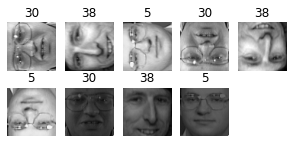

In [229]:
n_rotated = 3
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [230]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [231]:
gm.score_samples(X_bad_faces_pca)

array([-2.43643164e+07, -1.89785391e+07, -3.78112290e+07, -3.20479100e+07,
       -1.37530658e+07, -2.92374264e+07, -1.05489938e+08, -1.19576310e+08,
       -6.74259851e+07])

The bad faces are all considered highly unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [232]:
gm.score_samples(X_train_pca[:10])

array([1163.02020811, 1134.03637351, 1156.32133058, 1170.67602928,
       1141.45404834, 1154.35204932, 1091.32894612, 1111.411493  ,
       1096.43048784, 1132.98982668])

13. Using Dimensionality Reduction Techniques for Anomaly Detection



*Exercise: Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. Then compute the reconstruction error for each image. Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.*

We already reduced the dataset using PCA earlier:

In [233]:
X_train_pca

array([[ 3.7808321e+00, -1.8547790e+00, -5.1440277e+00, ...,
        -1.3562325e-01, -2.1408355e-01,  6.1186515e-02],
       [ 1.0148822e+01, -1.5275446e+00, -7.6703393e-01, ...,
         1.2393360e-01, -1.3526942e-01, -2.3266854e-02],
       [-1.0015291e+01,  2.8772719e+00, -9.1988486e-01, ...,
         7.2607487e-02, -2.9597613e-03,  1.2488555e-01],
       ...,
       [ 2.4758611e+00,  2.9559693e+00,  1.2998576e+00, ...,
        -2.0903669e-02,  3.4857798e-02, -1.5433593e-01],
       [-3.2203157e+00,  5.3489776e+00,  1.3942631e+00, ...,
         5.7549786e-02, -2.2831374e-01,  1.5557544e-01],
       [-9.2287493e-01, -3.6470284e+00,  2.2608831e+00, ...,
         1.3684890e-01, -6.9136895e-02,  6.2694617e-02]], dtype=float32)

In [234]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [235]:
reconstruction_errors(pca, X_train).mean()

0.0001920535

In [236]:
reconstruction_errors(pca, X_bad_faces).mean()

0.0039320993

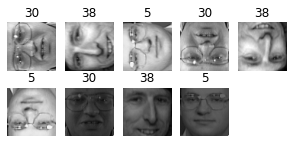

In [237]:
plot_faces(X_bad_faces, y_bad)

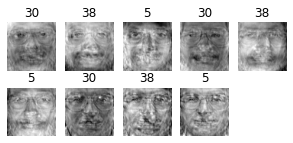

In [238]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)